# Isolate each key

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from scipy.spatial import ConvexHull, Delaunay

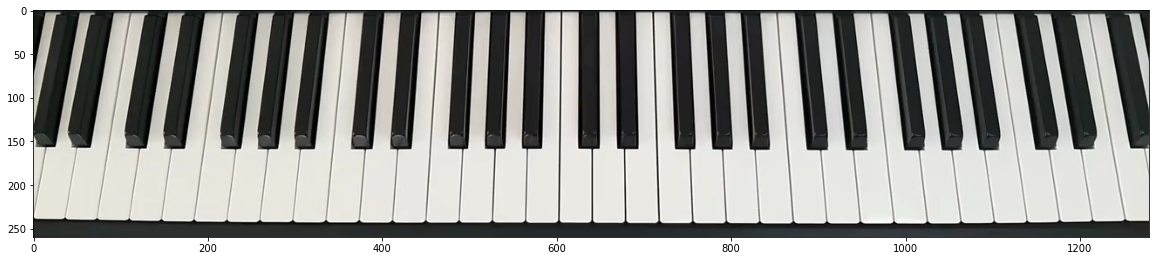

In [2]:
image = cv2.imread('pictures/frame0.png')
plt.figure(figsize=(20,10))
plt.imshow(image)
plt.show()

In [5]:
def pipeline_isolate_key(image):

    # sobel
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=5)
    sobel = np.sqrt(10*sobelx**2 + sobely**2) # 10 is a scaling factor to make the vertical edges more visible

    # threshold
    threshold = 5000
    sobel_with_threshold = sobel.copy()
    sobel_with_threshold[sobel_with_threshold <= threshold] = 255
    sobel_with_threshold[sobel_with_threshold > threshold] = 0
    sobel_with_threshold[0:5,:] = 0 # make a white line to separate the black keys
    sobel_with_threshold = sobel_with_threshold.astype(np.uint8)
    #plt.figure(figsize=(20,10))
    #plt.imshow(sobel_with_threshold, cmap='gray')
    #plt.show()

    # min pooling along horizontal axis to remove some holes between the keys where y is betweent 157 and 240
    for i in range(157, 240):
        for j in range(3, 1280-3):
            if (sobel_with_threshold[i, j] == 255
                and (sobel_with_threshold[i, j-1] == 0 or sobel_with_threshold[i, j-2] == 0 or sobel_with_threshold[i, j-3] == 0)
                and (sobel_with_threshold[i, j+1] == 0 or sobel_with_threshold[i, j+2] == 0 or sobel_with_threshold[i, j+3] == 0)):
                sobel_with_threshold[i, j] = 0

    # get the connected components
    ret, labels = cv2.connectedComponents(sobel_with_threshold)

    # some connected components are too small, so we remove them
    for i in range(1, len(np.unique(labels))):
        if np.sum(labels == i) < 500:
            labels[labels == i] = 0
    # the second biggest connected component is the background at the bottom so we remove it (the biggest connected component are the edges)
    labels[labels == np.argsort(np.bincount(labels.flatten()))[-2]] = 0

    # rename the connected components
    labels[labels > 0] = 255
    labels = labels.astype(np.uint8)
    ret, labels = cv2.connectedComponents(labels)
    number = len(np.unique(labels))
    labels[labels > 0] = labels[labels > 0] #+ 20 # add 20 to the labels to make the regions easier to see
    print("The number of keys is", number-1) # -1 because 0 is the background

    # the key numbers are not in the right order, so we need to reorder them by using
    # the x coordinates of the centroids of the connected components

    # get the centroids of the connected components
    centroids = [(i, np.mean(np.where(labels == i), axis=1)[1]) for i in range(1, number)]

    # reorder the keys
    keys = sorted(centroids, key=lambda x: x[1])

    # reassigning the labels
    new_labels = np.zeros_like(labels)
    for i in range(1, number):
        new_labels[labels == keys[i-1][0]] = i

    # Goal : erase the noise in the black keys
    # We will use the fact that the black keys are convex
    # So we will find the convex hull of each black key and fill it with white
    
    centroids = [(i,np.mean(np.where(new_labels == i), axis=1)[0])
                for i in range(2, number-1)] # we exclude the first and last keys because they are not complete
    # only keep the index of the black keys which have a y-centroid between less than 100
    black_keys = [c[0] for c in centroids if c[1] < 100]

    # get the convex hull of each black key
    def get_convex_hull(labels, key_number):
        # get the coordinates of the pixels of the key
        X,Y = np.where(labels == key_number)
        # get the convex hull
        hull = ConvexHull(np.array([X,Y]).T)
        return hull

    # check if a point is inside a convex hull
    def is_inside_hull(hull, point):
        # get the vertices of the convex hull
        vertices = hull.points[hull.vertices]
        # get the Delaunay triangulation of the vertices
        tri = Delaunay(vertices)
        # check if the point is inside the convex hull
        return tri.find_simplex(point) >= 0

    # fill the convex hull of a black key with white
    def fill_hull(labels, key_number):
        new_labels = labels.copy()
        # get the convex hull
        hull = get_convex_hull(new_labels, key_number)
        # fill the convex hull with white
        # get xmin, xmax, ymin, ymax of the convex hull to limit the search
        xmin = np.min(hull.points[hull.vertices,0])
        xmax = np.max(hull.points[hull.vertices,0])
        ymin = np.min(hull.points[hull.vertices,1])
        ymax = np.max(hull.points[hull.vertices,1])
        for x in range(int(xmin), int(xmax)+1):
            for y in range(int(ymin), int(ymax)+1):
                if new_labels[x,y] == 0 and is_inside_hull(hull, (x,y)):
                    new_labels[x,y] = key_number
        return new_labels

    # fill the convex hull of each black key with white
    new_labels_filled = new_labels.copy()
    for i in black_keys:
        new_labels_filled = fill_hull(new_labels_filled, i)
    
    return new_labels_filled


# highlight each keys
# where labels == key_number, set new_labels to 255,
# where labels == 0, set new_labels to 0,
# where labels != key_number and labels != 0, set new_labels to 100
def highlight_key(labels, key_number):
    new_labels = np.zeros_like(labels)
    new_labels[labels == key_number] = 255
    new_labels[labels == 0] = 0
    new_labels[(labels != key_number) & (labels != 0)] = 100
    return new_labels

labels = pipeline_isolate_key(image)
number = len(np.unique(labels))-1

The number of keys is 60


In [6]:
def show_key(key_number):
    plt.figure(figsize=(20,10))
    plt.imshow(highlight_key(labels, key_number), cmap='gray')
    plt.show()

interact(show_key, key_number=(1, number, 1))

interactive(children=(IntSlider(value=30, description='key_number', max=60, min=1), Output()), _dom_classes=('…

<function __main__.show_key(key_number)>

In [7]:
def highlight_key_from_image(image, labels, key_number):
    new_image = image.copy()
    new_image[labels == key_number] = [0,255,0]
    return new_image

def show_key_from_image(key_number):
    plt.figure(figsize=(20,10))
    plt.imshow(highlight_key_from_image(image, labels, key_number))
    plt.show()

interact(show_key_from_image, key_number=(1, number, 1))

interactive(children=(IntSlider(value=30, description='key_number', max=60, min=1), Output()), _dom_classes=('…

<function __main__.show_key_from_image(key_number)>